In [1]:
import pandas as pd
import numpy as np
import math

import os
from tqdm import tqdm
import json
import shutil

# image data
from PIL import Image
# import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from glob import glob
import matplotlib.pyplot as plt

# import sklearn #필요

### 1. GPU setting

In [ ]:
# gpus =tf.config.experimental.list_physical_devices('GPU')
# if gpus: 
#     # tensorflow가 첫번째 gpu만 사용하도록 제한
#     try: 
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#     except RuntimeError as e: 
#         print(e)

In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
#tf.test.is_gpu_available()
#tf.test.is_built_with_cuda()
tf.test.is_built_with_gpu_support()

True

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
!nvidia-smi

### Visualization

In [ ]:
# visualization - only mass
lst = glob('/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/ART/02_01_0001_*')

test = Image.open(lst[0])
plt.figure(figsize = (10, 10))
for i in range(1, len(lst)): 
    tmp = Image.open(lst[i])
    test = np.concatenate((test, tmp), axis = 1)

plt.imshow(test)

In [ ]:
# visualization - only mass
lst = glob('/home/ncp/workspace/blocks1/kidneyData_windowing_mass/Train_data/ART/02_01_0002_*')

test = Image.open(lst[0])
plt.figure(figsize = (10, 10))
for i in range(1, len(lst)): 
    tmp = Image.open(lst[i])
    test = np.concatenate((test, tmp), axis = 1)
    
plt.imshow(test)

In [ ]:
# visualization - only mass
lst = glob('/home/ncp/workspace/blocks1/kidneyData_windowing_mass/Train_data/ART/02_01_0003_*')

test = Image.open(lst[0])
plt.figure(figsize = (20, 20))
for i in range(1, len(lst)): 
    tmp = Image.open(lst[i])
    test = np.concatenate((test, tmp), axis = 1)

plt.imshow(test)

In [ ]:
# visualization - only mass - ppl 1 from 9

for idx in range(1, 10): 
    lst = glob('/home/ncp/workspace/blocks1/kidneyData_windowing_mass/Train_data/ART/02_01_000{}_*'.format(idx))

    test = Image.open(lst[0])
    plt.figure(figsize = (20, 20))
    for i in range(1, len(lst)): 
        tmp = Image.open(lst[i])
        test = np.concatenate((test, tmp), axis = 1)
        
    print("patient index: ", idx)
    plt.imshow(test)

In [ ]:
# visualization - only mass - ppl 10 from 30

for idx in range(10, 31): 
    lst = glob('/home/ncp/workspace/blocks1/kidneyData_windowing_mass/Train_data/ART/02_01_00{}_*'.format(idx))

    test = Image.open(lst[0])
    plt.figure(figsize = (20, 20))
    for i in range(1, len(lst)): 
        tmp = Image.open(lst[i])
        test = np.concatenate((test, tmp), axis = 1)
        
    print("patient index: ", idx)
    plt.imshow(test)

### count min max

In [ ]:
patient = pd.DataFrame(os.listdir('/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/ART/'))
patient['id'] = patient[0].str[0:10]
tmp = patient.groupby(['id']).count().sort_values([0], ascending = False)
tmp[[0]].value_counts()
# min 1
# max 22

In [ ]:
patient = pd.DataFrame(os.listdir('/home/ncp/workspace/blocks1/kidneyData_windowing_mass/Train_data/PRE/'))
patient['id'] = patient[0].str[0:10]
patient.groupby(['id']).count().sort_values([0], ascending = False)
# min 1
# max 21

In [ ]:
patient = pd.DataFrame(os.listdir('/home/ncp/workspace/blocks1/kidneyData_windowing_mass/Test_data/ART/'))
patient['id'] = patient[0].str[0:10]
patient.groupby(['id']).count().sort_values([0], ascending = False)
# min 2
# max 19

In [ ]:
patient = pd.DataFrame(os.listdir('/home/ncp/workspace/blocks1/kidneyData_windowing_mass/Test_data/PRE/'))
patient['id'] = patient[0].str[0:10]
patient.groupby(['id']).count().sort_values([0], ascending = False)
# min 2
# max 18

### DCM header check

In [ ]:
# dcm header check
import pydicom

path__ = '/home/ncp/workspace/202002n035/035.신장암 진단을 위한 의료 영상 데이터/01.데이터/신장암2/1.Training/원천데이터/02_01_0001/02_01_0001_ART/0001.dcm'
header_01 = pydicom.dcmread(path__, stop_before_pixels = True)
header_01

In [ ]:
df = pd.DataFrame(columns = ['name', 'modality'])
data = [{'name' : '0', 'modality': str(header_01[0x0008, 0x0001030][0:])}]
tmp = pd.DataFrame(data)
tmp

In [ ]:
# dcm header별 modality list
path = '/home/ncp/workspace/202002n035/035.신장암 진단을 위한 의료 영상 데이터/01.데이터/신장암2/1.Training/원천데이터/'
patient = os.listdir(path)
df = pd.DataFrame(columns = ['name', 'modality'])
lst = []

for ppl in patient: 
    deep_path = path + ppl + '/' + '{}_ART'.format(ppl) + '/'
    filelist = os.listdir(deep_path)
    for file in filelist: 
        try: 
            header = pydicom.dcmread(deep_path + file, stop_before_pixels = True)
            data = [{'name' : ppl, 'modality': str(header[0x0008, 0x0001030][0:])}]
            tmp = pd.DataFrame(data)
            df = pd.concat([df, tmp], axis = 0)
        except Exception: 
            lst.append(ppl)
            pass

In [ ]:
df

In [ ]:
df['modality'].unique()

In [ ]:
df_groupby = df.groupby(['modality']).count().reset_index()
df_groupby

In [ ]:
set(lst)

In [ ]:
modality_kidney_list = df.loc[df['modality'].isin(['CT Kidney (3P) + 3D', 'CT Kidney (3P) + 3D (contrast)']) == True, 'name'].unique()
len(modality_kidney_list)

In [ ]:
modality_kidney_list

In [ ]:
modality_pelvis_list = df.loc[df['modality'].isin(['Pelvis^00_Kidney_3D (Adult)']) == True, 'name'].unique()
len(modality_pelvis_list)

In [ ]:
# 사람별 ct 이미지 장수 확인

n_list = []

for ppl in modality_kidney_list: 
    lst = glob('/home/ncp/workspace/blocks1/kidneyData_windowing/TRAIN/ART/{}_*'.format(ppl))
    lst.sort()
    n_list.append(len(lst))
    print(ppl, "N: ", len(lst))

In [ ]:
# 사람별 ct 이미지 장수 확인

n_list = []

for ppl in modality_pelvis_list: 
    lst = glob('/home/ncp/workspace/blocks1/kidneyData_windowing/TRAIN/ART/{}_*'.format(ppl))
    lst.sort()
    n_list.append(len(lst))
    print(ppl, "N: ", len(lst))

In [ ]:
n_list = pd.DataFrame(n_list)

In [ ]:
n_list[0].describe()

In [ ]:
# 0장인 사람이?
# 0drop후 describe

n_list = n_list.loc[n_list[0] != 0].reset_index(drop = True)
n_list[0].describe()

### 2. Build train and validation datasets

In [ ]:
# # 전체 데이터 쓸 때 실행
# # abnormal : RCC (악성)
# # normal : aml + onco (양성)

# ART_train_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TRAIN/ART/'
# ART_test_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TEST/ART/'
# PRE_train_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TRAIN/PRE/'
# PRE_test_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TEST/PRE/'

In [10]:
# mass 만 쓸 때 실행 - mass 데이터를 악성 양성으로 분류해서 저장한 경로 참조
# abnormal : RCC (악성)
# normal : aml + onco (양성)

ART_train_path = '/home/ncp/workspace/blocks2/kidneyData_windowing_mass_classified/TRAIN/ART/'
ART_test_path = '/home/ncp/workspace/blocks2/kidneyData_windowing_mass_classified/TEST/ART/'
PRE_train_path = '/home/ncp/workspace/blocks2/kidneyData_windowing_mass_classified/TRAIN/PRE/'
PRE_test_path = '/home/ncp/workspace/blocks2/kidneyData_windowing_mass_classified/TEST/PRE/'
GCCT_train_path = '/home/ncp/workspace/blocks2/kidneyData_windowing_mass_classified/TRAIN/GCCT/'
GCCT_test_path = '/home/ncp/workspace/blocks2/kidneyData_windowing_mass_classified/TEST/GCCT/'

In [7]:
def process_scan(path): 
    # read scan
    volume = Image.open(path).convert('L')
    volume = np.array(volume)

    return volume

In [ ]:
# # 전체 데이터용

# def padding_stacking(data_path, cancer_type): 
#     ## create distinct list of patients ##
#     file_list = os.listdir(data_path + cancer_type + '/')
#     patient = []
#     for items in file_list: 
#         patient.append(items[0:10])

#     patient = list(set(patient))
#     print("total distinct patient N: ", len(patient))

#     ## create empty datasets ##
#     scans_final = np.zeros((512, 512, 128))
#     ppl_scan_list = []

#     ## iterate through distinct patient list and process ##
#     for ppl in patient: 

#         ## 사람별로 path list 생성, path list에서 ct 불러와서 stack ## 
#         ## (512, 512, n) 장의 file 생성됨 ##
#         ppl_path = []
#         ppl_scan = np.zeros((512, 512))
#         for x in os.listdir(data_path + cancer_type + '/'): 
#             if x[0:10] == ppl: 
#                 ppl_path.append(x)
#         for path in ppl_path: 
#             ppl_scan = np.dstack((ppl_scan, process_scan(data_path + cancer_type + '/' + path)))  # one layer of zero padding added on top

#         print("patient id: ", ppl)
#         print("ppl_scan shape: ", ppl_scan.shape)

#         ## zero pad to (512, 512, 128) ##
#         height, width, depth = ppl_scan.shape
#         pad_len = (128-depth)//2 # 양쪽에 padding 할 length 정의

#         if depth >= 128: # if depth >= 128 then truncate
#             if depth % 2 == 0: 
#                 pad_len = (depth-128)//2
#                 ppl_scan_padded = ppl_scan[:, :, pad_len:depth-pad_len]
#                 print("padded ppl_scan shape: ", ppl_scan_padded.shape)
#             else: 
#                 pad_len = (depth-128)//2
#                 ppl_scan_padded = ppl_scan[:, :, pad_len:depth-pad_len-1]
#                 print("padded ppl_scan shape: ", ppl_scan_padded.shape)
#         else: # if depth < 128 than pad
#             if depth % 2 == 0: 
#                 ppl_scan_padded = np.pad(ppl_scan, ((0,0), (0,0), (pad_len, pad_len)), 'constant')
#                 print("padded ppl_scan shape: ", ppl_scan_padded.shape)
#             else: 
#                 ppl_scan_padded = np.pad(ppl_scan, ((0,0), (0,0), (pad_len, pad_len+1)), 'constant')
#                 print("padded ppl_scan shape: ", ppl_scan_padded.shape)

#         ppl_scan_list.append(ppl_scan_padded) # padding 완료된 file을 ppl_scan_list 에 저장
#         print("---------------------") 

#     # 사람별 생성 및 process 된 ppl_scan을 순회하면서 (N, 512, 512, 128) 로 저장 ##
#     scans_final = np.array([ppl_scan_list[i] for i in range(len(ppl_scan_list))])
#     print("scans_final shape: ", scans_final.shape) 
    
#     return scans_final

In [ ]:
# mass 데이터용 - PADDING 64

def padding_stacking(data_path, cancer_type): 
    ## create distinct list of patients ##
    file_list = os.listdir(data_path + cancer_type + '/')
    patient = []
    for items in file_list: 
        patient.append(items[0:10])

    patient = list(set(patient))
    print("total distinct patient N: ", len(patient))

    ## create empty datasets ##
    scans_final = np.zeros((512, 512, 64))
    ppl_scan_list = []

    ## iterate through distinct patient list and process ##
    for ppl in patient: 

        ## 사람별로 path list 생성, path list에서 ct 불러와서 stack ## 
        ## (512, 512, n) 장의 file 생성됨 ##
        ppl_path = []
        ppl_scan = np.zeros((512, 512))
        for x in os.listdir(data_path + cancer_type + '/'): 
            if x[0:10] == ppl: 
                ppl_path.append(x)
        for path in ppl_path: 
            ppl_scan = np.dstack((ppl_scan, process_scan(data_path + cancer_type + '/' + path)))  # one layer of zero padding added on top

        print("patient id: ", ppl)
        print("ppl_scan shape: ", ppl_scan.shape)

        ## zero pad to (512, 512, 64) ##
        height, width, depth = ppl_scan.shape
        pad_len = (64-depth)//2 # 양쪽에 padding 할 length 정의

        if depth >= 64: # if depth >= 64 then truncate
            if depth % 2 == 0: 
                pad_len = (depth-64)//2
                ppl_scan_padded = ppl_scan[:, :, pad_len:depth-pad_len]
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)
            else: 
                pad_len = (depth-64)//2
                ppl_scan_padded = ppl_scan[:, :, pad_len:depth-pad_len-1]
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)
        else: # if depth < 64 than pad
            if depth % 2 == 0: 
                ppl_scan_padded = np.pad(ppl_scan, ((0,0), (0,0), (pad_len, pad_len)), 'constant')
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)
            else: 
                ppl_scan_padded = np.pad(ppl_scan, ((0,0), (0,0), (pad_len, pad_len+1)), 'constant')
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)

        ppl_scan_list.append(ppl_scan_padded) # padding 완료된 file을 ppl_scan_list 에 저장
        print("---------------------") 

    # 사람별 생성 및 process 된 ppl_scan을 순회하면서 (N, 512, 512, 64) 로 저장 ##
    scans_final = np.array([ppl_scan_list[i] for i in range(len(ppl_scan_list))])
    print("scans_final shape: ", scans_final.shape) 
    
    return scans_final

In [8]:
# mass 데이터용 - PADDING 32

def padding_stacking(data_path, cancer_type): 
    ## create distinct list of patients ##
    file_list = os.listdir(data_path + cancer_type + '/')
    patient = []
    for items in file_list: 
        patient.append(items[0:10])

    patient = list(set(patient))
    print("total distinct patient N: ", len(patient))

    ## create empty datasets ##
    scans_final = np.zeros((512, 512, 32))
    ppl_scan_list = []

    ## iterate through distinct patient list and process ##
    for ppl in patient: 

        ## 사람별로 path list 생성, path list에서 ct 불러와서 stack ## 
        ## (512, 512, n) 장의 file 생성됨 ##
        ppl_path = []
        ppl_scan = np.zeros((512, 512))
        for x in os.listdir(data_path + cancer_type + '/'): 
            if x[0:10] == ppl: 
                ppl_path.append(x)
        for path in ppl_path: 
            ppl_scan = np.dstack((ppl_scan, process_scan(data_path + cancer_type + '/' + path)))  # one layer of zero padding added on top

        print("patient id: ", ppl)
        print("ppl_scan shape: ", ppl_scan.shape)

        ## zero pad to (512, 512, 32) ##
        height, width, depth = ppl_scan.shape
        pad_len = (32-depth)//2 # 양쪽에 padding 할 length 정의

        if depth >= 32: # if depth >= 32 then truncate
            if depth % 2 == 0: 
                pad_len = (depth-32)//2
                ppl_scan_padded = ppl_scan[:, :, pad_len:depth-pad_len]
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)
            else: 
                pad_len = (depth-32)//2
                ppl_scan_padded = ppl_scan[:, :, pad_len:depth-pad_len-1]
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)
        else: # if depth < 32 than pad
            if depth % 2 == 0: 
                ppl_scan_padded = np.pad(ppl_scan, ((0,0), (0,0), (pad_len, pad_len)), 'constant')
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)
            else: 
                ppl_scan_padded = np.pad(ppl_scan, ((0,0), (0,0), (pad_len, pad_len+1)), 'constant')
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)

        ppl_scan_list.append(ppl_scan_padded) # padding 완료된 file을 ppl_scan_list 에 저장
        print("---------------------") 

    # 사람별 생성 및 process 된 ppl_scan을 순회하면서 (N, 512, 512, 32) 로 저장 ##
    scans_final = np.array([ppl_scan_list[i] for i in range(len(ppl_scan_list))])
    print("scans_final shape: ", scans_final.shape) 
    
    return scans_final

In [17]:
# mass 데이터용 - PADDING 16

def padding_stacking(data_path, cancer_type): 
    ## create distinct list of patients ##
    file_list = os.listdir(data_path + cancer_type + '/')
    patient = []
    for items in file_list: 
        patient.append(items[0:10])

    patient = list(set(patient))
    print("total distinct patient N: ", len(patient))

    ## create empty datasets ##
    scans_final = np.zeros((512, 512, 16))
    ppl_scan_list = []

    ## iterate through distinct patient list and process ##
    for ppl in patient: 

        ## 사람별로 path list 생성, path list에서 ct 불러와서 stack ## 
        ## (512, 512, n) 장의 file 생성됨 ##
        ppl_path = []
        ppl_scan = np.zeros((512, 512))
        for x in os.listdir(data_path + cancer_type + '/'): 
            if x[0:10] == ppl: 
                ppl_path.append(x)
        for path in ppl_path: 
            ppl_scan = np.dstack((ppl_scan, process_scan(data_path + cancer_type + '/' + path)))  # one layer of zero padding added on top

        print("patient id: ", ppl)
        print("ppl_scan shape: ", ppl_scan.shape)

        ## zero pad to (512, 512, 16) ##
        height, width, depth = ppl_scan.shape
        pad_len = (16-depth)//2 # 양쪽에 padding 할 length 정의

        if depth >= 16: # if depth >= 16 then truncate
            if depth % 2 == 0: 
                pad_len = (depth-16)//2
                ppl_scan_padded = ppl_scan[:, :, pad_len:depth-pad_len]
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)
            else: 
                pad_len = (depth-16)//2
                ppl_scan_padded = ppl_scan[:, :, pad_len:depth-pad_len-1]
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)
        else: # if depth < 16 than pad
            if depth % 2 == 0: 
                ppl_scan_padded = np.pad(ppl_scan, ((0,0), (0,0), (pad_len, pad_len)), 'constant')
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)
            else: 
                ppl_scan_padded = np.pad(ppl_scan, ((0,0), (0,0), (pad_len, pad_len+1)), 'constant')
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)

        ppl_scan_list.append(ppl_scan_padded) # padding 완료된 file을 ppl_scan_list 에 저장
        print("---------------------") 

    # 사람별 생성 및 process 된 ppl_scan을 순회하면서 (N, 512, 512, 16) 로 저장 ##
    scans_final = np.array([ppl_scan_list[i] for i in range(len(ppl_scan_list))])
    print("scans_final shape: ", scans_final.shape) 
    
    return scans_final

In [43]:
# mass 데이터용 - PADDING 8

def padding_stacking(data_path, cancer_type): 
    ## create distinct list of patients ##
    file_list = os.listdir(data_path + cancer_type + '/')
    patient = []
    for items in file_list: 
        patient.append(items[0:10])

    patient = list(set(patient))
    print("total distinct patient N: ", len(patient))

    ## create empty datasets ##
    scans_final = np.zeros((512, 512, 8))
    ppl_scan_list = []

    ## iterate through distinct patient list and process ##
    for ppl in patient: 

        ## 사람별로 path list 생성, path list에서 ct 불러와서 stack ## 
        ## (512, 512, n) 장의 file 생성됨 ##
        ppl_path = []
        ppl_scan = np.zeros((512, 512))
        for x in os.listdir(data_path + cancer_type + '/'): 
            if x[0:10] == ppl: 
                ppl_path.append(x)
        for path in ppl_path: 
            ppl_scan = np.dstack((ppl_scan, process_scan(data_path + cancer_type + '/' + path)))  # one layer of zero padding added on top

        print("patient id: ", ppl)
        print("ppl_scan shape: ", ppl_scan.shape)

        ## zero pad to (512, 512, 8) ##
        height, width, depth = ppl_scan.shape
        pad_len = (8-depth)//2 # 양쪽에 padding 할 length 정의

        if depth >= 8: # if depth >= 8 then truncate
            if depth % 2 == 0: 
                pad_len = (depth-8)//2
                ppl_scan_padded = ppl_scan[:, :, pad_len:depth-pad_len]
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)
            else: 
                pad_len = (depth-8)//2
                ppl_scan_padded = ppl_scan[:, :, pad_len:depth-pad_len-1]
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)
        else: # if depth < 8 than pad
            if depth % 2 == 0: 
                ppl_scan_padded = np.pad(ppl_scan, ((0,0), (0,0), (pad_len, pad_len)), 'constant')
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)
            else: 
                ppl_scan_padded = np.pad(ppl_scan, ((0,0), (0,0), (pad_len, pad_len+1)), 'constant')
                print("padded ppl_scan shape: ", ppl_scan_padded.shape)

        ppl_scan_list.append(ppl_scan_padded) # padding 완료된 file을 ppl_scan_list 에 저장
        print("---------------------") 

    # 사람별 생성 및 process 된 ppl_scan을 순회하면서 (N, 512, 512, 16) 로 저장 ##
    scans_final = np.array([ppl_scan_list[i] for i in range(len(ppl_scan_list))])
    print("scans_final shape: ", scans_final.shape) 
    
    return scans_final

ART train : RCC (abnormal)

In [44]:
ART_train_abnormal_scans = padding_stacking(ART_train_path, 'RCC')

total distinct patient N:  153
patient id:  02_01_0304
ppl_scan shape:  (512, 512, 9)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0014
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0098
ppl_scan shape:  (512, 512, 14)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0226
ppl_scan shape:  (512, 512, 5)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0213
ppl_scan shape:  (512, 512, 7)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0186
ppl_scan shape:  (512, 512, 3)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0053
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0250
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0030
ppl_scan shape:  (512, 5

patient id:  02_01_0133
ppl_scan shape:  (512, 512, 8)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0192
ppl_scan shape:  (512, 512, 7)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0294
ppl_scan shape:  (512, 512, 3)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0297
ppl_scan shape:  (512, 512, 9)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0104
ppl_scan shape:  (512, 512, 5)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0125
ppl_scan shape:  (512, 512, 9)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0033
ppl_scan shape:  (512, 512, 14)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0203
ppl_scan shape:  (512, 512, 17)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0310
ppl_scan shape:  (512, 512, 9)
padded ppl_scan shape: 

patient id:  02_01_0306
ppl_scan shape:  (512, 512, 11)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0152
ppl_scan shape:  (512, 512, 8)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0284
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0302
ppl_scan shape:  (512, 512, 5)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0156
ppl_scan shape:  (512, 512, 5)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0285
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0320
ppl_scan shape:  (512, 512, 5)
padded ppl_scan shape:  (512, 512, 8)
---------------------
scans_final shape:  (153, 512, 512, 8)


ART train: AML + onco (normal)

In [45]:
ART_train_normal_scans = padding_stacking(ART_train_path, 'AML + onco')

total distinct patient N:  162
patient id:  02_01_0024
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0214
ppl_scan shape:  (512, 512, 3)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0174
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0063
ppl_scan shape:  (512, 512, 11)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0016
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0011
ppl_scan shape:  (512, 512, 7)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0198
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0265
ppl_scan shape:  (512, 512, 8)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0177
ppl_scan shape:  (512, 5

patient id:  02_01_0168
ppl_scan shape:  (512, 512, 8)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0240
ppl_scan shape:  (512, 512, 21)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0252
ppl_scan shape:  (512, 512, 18)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0159
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0145
ppl_scan shape:  (512, 512, 14)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0146
ppl_scan shape:  (512, 512, 9)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0267
ppl_scan shape:  (512, 512, 13)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0154
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0059
ppl_scan shape:  (512, 512, 4)
padded ppl_scan shape

patient id:  02_01_0149
ppl_scan shape:  (512, 512, 9)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0095
ppl_scan shape:  (512, 512, 9)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0101
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0237
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0206
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0282
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0089
ppl_scan shape:  (512, 512, 5)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0258
ppl_scan shape:  (512, 512, 4)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0224
ppl_scan shape:  (512, 512, 20)
padded ppl_scan shape:  

ART test: RCC (abnormal)

In [46]:
ART_test_abnormal_scans = padding_stacking(ART_test_path, 'RCC')

total distinct patient N:  27
patient id:  02_01_0327
ppl_scan shape:  (512, 512, 5)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0330
ppl_scan shape:  (512, 512, 12)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0341
ppl_scan shape:  (512, 512, 15)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0349
ppl_scan shape:  (512, 512, 13)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0347
ppl_scan shape:  (512, 512, 6)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0351
ppl_scan shape:  (512, 512, 9)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0357
ppl_scan shape:  (512, 512, 5)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0333
ppl_scan shape:  (512, 512, 7)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0334
ppl_scan shape:  (512, 

ART test: AML + onco (normal)

In [47]:
ART_test_normal_scans = padding_stacking(ART_test_path, 'AML + onco')

total distinct patient N:  12
patient id:  02_01_0360
ppl_scan shape:  (512, 512, 4)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0352
ppl_scan shape:  (512, 512, 8)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0321
ppl_scan shape:  (512, 512, 9)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0342
ppl_scan shape:  (512, 512, 5)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0335
ppl_scan shape:  (512, 512, 3)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0331
ppl_scan shape:  (512, 512, 12)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0359
ppl_scan shape:  (512, 512, 9)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0328
ppl_scan shape:  (512, 512, 10)
padded ppl_scan shape:  (512, 512, 8)
---------------------
patient id:  02_01_0339
ppl_scan shape:  (512, 5

PRE train: RCC (abnormal)

In [ ]:
PRE_train_abnormal_scans = padding_stacking(PRE_train_path, 'RCC')

PRE train: AML + onco (normal)

In [ ]:
PRE_train_normal_scans = padding_stacking(PRE_train_path, 'AML + onco')

PRE test: RCC (abnormal)

In [ ]:
PRE_test_abnormal_scans = padding_stacking(PRE_test_path, 'RCC')

PRE test: AML + onco (normal)

In [ ]:
PRE_test_normal_scans = padding_stacking(PRE_test_path, 'AML + onco')

GCCT train: RCC (abnormal)

In [ ]:
GCCT_train_abnormal_scans = padding_stacking(GCCT_train_path, 'RCC')

GCCT train: AML + onco (normal)

In [ ]:
GCCT_train_normal_scans = padding_stacking(GCCT_train_path, 'AML + onco')

GCCT test: RCC (abnormal)

In [ ]:
GCCT_test_abnormal_scans = padding_stacking(GCCT_test_path, 'RCC')

GCCT test: AML + onco (normal)

In [ ]:
GCCT_test_normal_scans = padding_stacking(GCCT_test_path, 'AML + onco')

### FINAL DATASETS

In [48]:
# ART
print("ART_train_abnormal_scans shape: ", ART_train_abnormal_scans.shape)
print("ART_train_normal_scans shape: ", ART_train_normal_scans.shape)
print("ART_test_abnormal_scans shape: ", ART_test_abnormal_scans.shape)
print("ART_test_normal_scans shape: ", ART_test_normal_scans.shape)

ART_train_abnormal_scans shape:  (153, 512, 512, 8)
ART_train_normal_scans shape:  (162, 512, 512, 8)
ART_test_abnormal_scans shape:  (27, 512, 512, 8)
ART_test_normal_scans shape:  (12, 512, 512, 8)


In [ ]:
# PRE
print("PRE_train_abnormal_scans shape: ", PRE_train_abnormal_scans.shape)
print("PRE_train_normal_scans shape: ", PRE_train_normal_scans.shape)
print("PRE_test_abnormal_scans shape: ", PRE_test_abnormal_scans.shape)
print("PRE_test_normal_scans shape: ", PRE_test_normal_scans.shape)

In [28]:
# GCCT
print("GCCT_train_abnormal_scans shape: ", GCCT_train_abnormal_scans.shape)
print("GCCT_train_normal_scans shape: ", GCCT_train_normal_scans.shape)
print("GCCT_test_abnormal_scans shape: ", GCCT_test_abnormal_scans.shape)
print("GCCT_test_normal_scans shape: ", GCCT_test_normal_scans.shape)

GCCT_train_abnormal_scans shape:  (152, 512, 512, 16)
GCCT_train_normal_scans shape:  (163, 512, 512, 16)
GCCT_test_abnormal_scans shape:  (27, 512, 512, 16)
GCCT_test_normal_scans shape:  (12, 512, 512, 16)


In [ ]:
# 하나의 set끼리만 build 해야 함!! (ART, PRE, GCCT 각각) (메모리 에러 남)

### Create data with Labels

In [50]:
# ART

ART_train_abnormal_labels = np.array([1 for _ in range(len(ART_train_abnormal_scans))])
ART_train_normal_labels = np.array([0 for _ in range(len(ART_train_normal_scans))])

# split 7:3 for validation
abnormal_train_idx = round(len(ART_train_abnormal_labels) * 0.7)
normal_train_idx = round(len(ART_train_normal_labels) * 0.7)

x_train = np.concatenate((ART_train_abnormal_scans[:abnormal_train_idx], ART_train_normal_scans[:normal_train_idx]), axis = 0)
y_train = np.concatenate((ART_train_abnormal_labels[:abnormal_train_idx], ART_train_normal_labels[:normal_train_idx]), axis = 0)

x_val = np.concatenate((ART_train_abnormal_scans[abnormal_train_idx:], ART_train_normal_scans[normal_train_idx:]), axis = 0)
y_val = np.concatenate((ART_train_abnormal_labels[abnormal_train_idx:], ART_train_normal_labels[normal_train_idx:]), axis = 0)

print("Number of samples in train and validation are %d and %d" %(x_train.shape[0], x_val.shape[0]))

Number of samples in train and validation are 220 and 95


In [ ]:
# PRE

PRE_train_abnormal_labels = np.array([1 for _ in range(len(PRE_train_abnormal_scans))])
PRE_train_normal_labels = np.array([0 for _ in range(len(PRE_train_normal_scans))])

# split 7:3 for validation
abnormal_train_idx = round(len(PRE_train_abnormal_labels) * 0.7)
normal_train_idx = round(len(PRE_train_normal_labels) * 0.7)

x_train = np.concatenate((PRE_train_abnormal_scans[:abnormal_train_idx], PRE_train_normal_scans[:normal_train_idx]), axis = 0)
y_train = np.concatenate((PRE_train_abnormal_labels[:abnormal_train_idx], PRE_train_normal_labels[:normal_train_idx]), axis = 0)

x_val = np.concatenate((PRE_train_abnormal_scans[abnormal_train_idx:], PRE_train_normal_scans[normal_train_idx:]), axis = 0)
y_val = np.concatenate((PRE_train_abnormal_labels[abnormal_train_idx:], PRE_train_normal_labels[normal_train_idx:]), axis = 0)

print("Number of samples in train and validation are %d and %d" %(x_train.shape[0], x_val.shape[0]))

In [29]:
# GCCT

GCCT_train_abnormal_labels = np.array([1 for _ in range(len(GCCT_train_abnormal_scans))])
GCCT_train_normal_labels = np.array([0 for _ in range(len(GCCT_train_normal_scans))])

# split 7:3 for validation
abnormal_train_idx = round(len(GCCT_train_abnormal_labels) * 0.7)
normal_train_idx = round(len(GCCT_train_normal_labels) * 0.7)

x_train = np.concatenate((GCCT_train_abnormal_scans[:abnormal_train_idx], GCCT_train_normal_scans[:normal_train_idx]), axis = 0)
y_train = np.concatenate((GCCT_train_abnormal_labels[:abnormal_train_idx], GCCT_train_normal_labels[:normal_train_idx]), axis = 0)

x_val = np.concatenate((GCCT_train_abnormal_scans[abnormal_train_idx:], GCCT_train_normal_scans[normal_train_idx:]), axis = 0)
y_val = np.concatenate((GCCT_train_abnormal_labels[abnormal_train_idx:], GCCT_train_normal_labels[normal_train_idx:]), axis = 0)

print("Number of samples in train and validation are %d and %d" %(x_train.shape[0], x_val.shape[0]))

Number of samples in train and validation are 220 and 95


In [51]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

In [52]:
train_loader

<TensorSliceDataset shapes: ((512, 512, 8), ()), types: (tf.float64, tf.int64)>

### MODEL

In [83]:
from tensorflow.keras.applications import InceptionResNetV2

In [ ]:
# InceptionResNetV2
img_size = 512
N_CLASSES = 2
base_model = InceptionResNetV2(include_top = False,
                   weights = 'imagenet',
                   input_shape = (img_size,img_size,8))

In [79]:
base_model.layers[-2].output

<tf.Tensor 'conv_7b_bn_1/Identity:0' shape=(None, 14, 14, 1536) dtype=float32>

In [ ]:
last = base_model.layers[-2].output
last = layers.MaxPool3D(pool_size = 2)(last)
last = layers.BatchNormalization()(last)
x = layers.GlobalAveragePooling3D()(last)
x = Dense(512,'relu')(x)
x = Dense(N_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

In [55]:
# def get_model(width = 512, height = 512, depth = 16):  # 기존 16
#     inputs = keras.Input((width, height, depth, 1))
    
# #     x = layers.Conv3D(filters = 32, kernel_size = 3, activation = "relu", padding='same')(inputs)
# #     x = layers.MaxPool3D(pool_size = 2)(x)
# #     x = layers.BatchNormalization()(x)
# #     print(x)

# #     x = layers.Conv3D(filters = 4, kernel_size = 3, activation = "relu", padding='same')(inputs)
# #     x = layers.MaxPool3D(pool_size = 2)(x)
# #     x = layers.BatchNormalization()(x)
# #     print(x)

#     x = layers.Conv3D(filters = 8, kernel_size = 3, activation = "relu", padding='same')(inputs)
#     x = layers.MaxPool3D(pool_size = 2)(x)
#     x = layers.BatchNormalization()(x)
#     print(x)

#     x = layers.Conv3D(filters = 16, kernel_size = 3, activation = "relu", padding='same')(inputs)
#     x = layers.MaxPool3D(pool_size = 2)(x)
#     x = layers.BatchNormalization()(x)
#     print(x)
    
#     x = layers.Conv3D(filters = 32, kernel_size = 3, activation = "relu", padding='same')(inputs)
#     x = layers.MaxPool3D(pool_size = 2)(x)
#     x = layers.BatchNormalization()(x)
#     print(x)
    
#     x = layers.Conv3D(filters = 64, kernel_size = 3, activation = "relu", padding='same')(x)
#     x = layers.MaxPool3D(pool_size = 2)(x)
#     x = layers.BatchNormalization()(x)
#     print(x)
    
#     x = layers.Conv3D(filters = 128, kernel_size = 3, activation = "relu", padding='same')(x)
#     x = layers.MaxPool3D(pool_size = 2)(x)
#     x = layers.BatchNormalization()(x)
#     print(x)
    
# #     x = layers.Conv3D(filters = 256, kernel_size = 3, activation = "relu", padding='same')(x)
# #     x = layers.MaxPool3D(pool_size = 2)(x)
# #     x = layers.BatchNormalization()(x)
# #     print(x)

# #     x = layers.Conv3D(filters = 512, kernel_size = 3, activation = "relu", padding='same')(x)
# #     x = layers.MaxPool3D(pool_size = 2)(x)
# #     x = layers.BatchNormalization()(x)
# #     print(x)
    
#     x = layers.GlobalAveragePooling3D()(x)
#     x = layers.Dense(units = 512, activation = "relu")(x)
#     x = layers.Dropout(0.3)(x)
#     print(x)
    
    
#     outputs = layers.Dense(units = 1, activation = "sigmoid")(x)
#     print(outputs)
    
#     model = keras.Model(inputs, outputs, name = "3dcnn")
    
#     return model

In [110]:
def get_model(width = 512, height = 512, depth = 8):  # 기존 16
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters = 64, kernel_size = 3, activation = "relu", padding='same')(inputs)
    x = layers.MaxPool3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)
    print(x)

    x = layers.Conv3D(filters = 64, kernel_size = 3, activation = "relu", padding='same')(inputs)
    x = layers.MaxPool3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)
    print(x)
    
    x = layers.Conv3D(filters = 128, kernel_size = 3, activation = "relu", padding='same')(inputs)
    x = layers.MaxPool3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)
    print(x)
    
#     x = layers.Conv3D(filters = 128, kernel_size = 3, activation = "relu", padding='same')(x)
#     x = layers.MaxPool3D(pool_size = 2)(x)
#     x = layers.BatchNormalization()(x)
#     print(x)
    
#     x = layers.Conv3D(filters = 256, kernel_size = 3, activation = "relu", padding='same')(x)
#     x = layers.MaxPool3D(pool_size = 2)(x)
#     x = layers.BatchNormalization()(x)
#     print(x)

#     x = layers.Conv3D(filters = 256, kernel_size = 3, activation = "relu", padding='same')(x)
#     x = layers.MaxPool3D(pool_size = 2)(x)
#     x = layers.BatchNormalization()(x)
#     print(x)
    
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units = 512, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    print(x)
    
    
    outputs = layers.Dense(units = 1, activation = "sigmoid")(x)
    print(outputs)
    
    model = keras.Model(inputs, outputs, name = "3dcnn")
    
    return model

In [111]:
model = get_model(width = 512, height = 512, depth = 8) # 기존 16
model.summary() 

Tensor("batch_normalization_437/Identity:0", shape=(None, 256, 256, 4, 64), dtype=float32)
Tensor("batch_normalization_438/Identity:0", shape=(None, 256, 256, 4, 64), dtype=float32)
Tensor("batch_normalization_439/Identity:0", shape=(None, 256, 256, 4, 128), dtype=float32)
Tensor("dropout_4/Identity:0", shape=(None, 512), dtype=float32)
Tensor("dense_9/Identity:0", shape=(None, 1), dtype=float32)
Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 512, 512, 8, 1)]  0         
_________________________________________________________________
conv3d_35 (Conv3D)           (None, 512, 512, 8, 128)  3584      
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 256, 256, 4, 128)  0         
_________________________________________________________________
batch_normalization_439 (Bat (None, 256, 256, 4, 128)  51

In [112]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
initial_learning_rate = 0.01
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps = 100000, decay_rate = 0.96, staircase = True
)
model.compile(
    loss = "binary_crossentropy", 
    optimizer = keras.optimizers.Adam(learning_rate = lr_schedule), 
    metrics = ["accuracy", "AUC"]
)

In [113]:
# ART - train

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "./CNN_3D_ART_epoch100_padding8.hdf5", save_best_only = True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_accuracy", verbose = 1, patience = 15)
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
#                                            patience =3, 
#                                            verbose =1,
#                                             factor = 0.2,
#                                             min_lr =0.0000001)

epochs = 100
history = model.fit(
        train_dataset,
        validation_data = validation_dataset, 
        epochs = epochs, 
        shuffle = True, 
        verbose = 2, 
#         callbacks = [checkpoint_cb, early_stopping_cb, learning_rate_reduction]
        callbacks = [checkpoint_cb, early_stopping_cb]
    )

Epoch 1/100
110/110 - 18s - loss: 0.9017 - accuracy: 0.4545 - auc: 0.4477 - val_loss: 0.6760 - val_accuracy: 0.6105 - val_auc: 0.6240
Epoch 2/100
110/110 - 18s - loss: 0.7414 - accuracy: 0.4409 - auc: 0.4094 - val_loss: 0.7104 - val_accuracy: 0.5158 - val_auc: 0.5211
Epoch 3/100
110/110 - 18s - loss: 0.7011 - accuracy: 0.4636 - auc: 0.4422 - val_loss: 0.6961 - val_accuracy: 0.5053 - val_auc: 0.5504
Epoch 4/100
110/110 - 18s - loss: 0.6945 - accuracy: 0.5091 - auc: 0.4881 - val_loss: 0.6864 - val_accuracy: 0.6211 - val_auc: 0.6739
Epoch 5/100
110/110 - 18s - loss: 0.7012 - accuracy: 0.5045 - auc: 0.4465 - val_loss: 0.6950 - val_accuracy: 0.5474 - val_auc: 0.4528
Epoch 6/100
110/110 - 18s - loss: 0.6931 - accuracy: 0.5091 - auc: 0.4517 - val_loss: 0.6944 - val_accuracy: 0.5368 - val_auc: 0.5421
Epoch 7/100
110/110 - 18s - loss: 0.6898 - accuracy: 0.5591 - auc: 0.5866 - val_loss: 0.6849 - val_accuracy: 0.5789 - val_auc: 0.6504
Epoch 8/100
110/110 - 18s - loss: 0.7346 - accuracy: 0.5091 - 

In [35]:
model = tf.keras.models.load_model('')

In [114]:
result = model.evaluate(validation_dataset)

48/48 [==============================] - 2s 48ms/step - loss: 0.6863 - accuracy: 0.5474 - auc: 0.5670


In [ ]:
# PRE - train

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "PRE_3d_image_classification-padding16.hdf5", save_best_only = True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_acc", patience = 15)

epochs = 200
history = model.fit(
        train_dataset,
        validation_data = validation_dataset, 
        epochs = epochs, 
        shuffle = True, 
        verbose = 2, 
        callbacks = [checkpoint_cb, early_stopping_cb]
    )

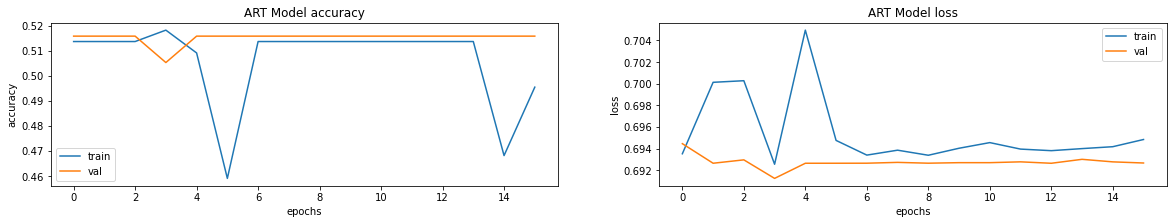

In [104]:
# visualize model performance - ART

fig, ax = plt.subplots(1, 2, figsize = (20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]): 
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("ART Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
# visualize model performance - PRE

fig, ax = plt.subplots(1, 2, figsize = (20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]): 
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("PRE Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [63]:
# make predictions on a multiple CT scans - ART

# n = 0  # random person
# load best weights
model.load_weights("CNN_3D_ART_epoch100_padding8_smallerparameters.hdf5")

for n in range(10): 
    prediction = model.predict(np.expand_dims(x_val[n], axis = 0))[0]
    scores = [1 - prediction[0], prediction[0]]

    class_names = ["normal", "abnormal"]
    for score, name in zip(scores, class_names): 
        print(
            "This model is %.2f percent confident that %dth CT scan is %s"
            % ((100*score), n, name)
        )
        if (y_val[n] == 1): 
            true_y = 'abnormal'
        else: 
            true_y = 'normal'
    print("The true value is: {}".format(true_y))
    print("-----------------------------")

This model is 46.43 percent confident that 0th CT scan is normal
This model is 53.57 percent confident that 0th CT scan is abnormal
The true value is: abnormal
-----------------------------
This model is 54.73 percent confident that 1th CT scan is normal
This model is 45.27 percent confident that 1th CT scan is abnormal
The true value is: abnormal
-----------------------------
This model is 42.64 percent confident that 2th CT scan is normal
This model is 57.36 percent confident that 2th CT scan is abnormal
The true value is: abnormal
-----------------------------
This model is 38.66 percent confident that 3th CT scan is normal
This model is 61.34 percent confident that 3th CT scan is abnormal
The true value is: abnormal
-----------------------------
This model is 48.60 percent confident that 4th CT scan is normal
This model is 51.40 percent confident that 4th CT scan is abnormal
The true value is: abnormal
-----------------------------
This model is 54.55 percent confident that 5th CT 

In [ ]:
# make predictions on a multiple CT scans - PRE

# n = 0  # random person
# load best weights
model.load_weights("PRE_3d_image_classification-padding16.hdf5")

for n in range(10): 
    prediction = model.predict(np.expand_dims(x_val[n], axis = 0))[0]
    scores = [1 - prediction[0], prediction[0]]

    class_names = ["normal", "abnormal"]
    for score, name in zip(scores, class_names): 
        print(
            "This model is %.2f percent confident that %dth CT scan is %s"
            % ((100*score), n, name)
        )
        if (y_val[n] == 1): 
            true_y = 'abnormal'
        else: 
            true_y = 'normal'
    print("The true value is: {}".format(true_y))
    print("-----------------------------")

In [64]:
# plot_confusion_matrix doesn't work with tensorflow models - solved, but memory error occurs

class estimator: 
    _estimator_type = ''
    classes = []
    def __init__(self, model, classes): 
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X): 
        y_prob = self.model.predict(X)
        y_pred = y_prob.argmax(axis = 1)
        return y_pred

In [ ]:
# confusion matrix

import sklearn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

classifier = estimator(model, label)

figsize = (6, 6)
label = ["normal", "abnormal"]
plot_confusion_matrix(estimator = classifier, 
                            X = x_val, 
                            y_true = y_val, 
                            display_labels = label, 
                            cmap = 'Blues', 
                            normalize = 'true',
                            ax = plt.subplots(figsize = figsize)[1])

In [ ]:
x_val.shape

In [ ]:
y_val.shape

In [ ]:
# try 3d visualization

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy
from scipy.spatial import Delaunay

def plot_basic_object(points): 
    tri = Delaunay(points).convex_hull
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    S = ax.plot_trisurf(points[:, 0], points[:, 1], points[:2], 
                       triangles = tri, 
                       shade = True, cmap = 'Blues', lw = 0.5)
    ax.set_xlim3d(-5, 5)
    ax.set_ylim3d(-5, 5)
    ax.set_zlim3d(-5, 5)
    
    plt.show()

In [ ]:
plot_basic_object(x_val[0])